In [26]:

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

np.random.seed(1)


m = 20 # number of devices
n = 5  # number of servers

wD = np.random.randint(1 ,4 ,m )
wS = np.random.randint(1 ,4 ,n )

BD = np.random.uniform(50, 80, m)
BS = np.random.uniform(100, 300, n)
CD = np.random.uniform(100, 200, m)

class Trace(object):
    def __init__(self):
        data = np.loadtxt('trace_data/Lumos5G-v1.0/Lumos5G-v1.0.csv', delimiter=',', skiprows=1, usecols=(0,15)).astype(int)
        self.traces = []
        for run in np.unique(data[:,0]):
            trace = data[data[:,0]==run, 1]
            trace = 1/(trace + 1)
            self.traces.append(trace)
        self.average = [np.average(trace) for trace in self.traces]
        self.trace_selection = np.random.choice(len(self.traces), (m,n))
        self.trace_counter = np.zeros_like(self.trace_selection)
        for i in range(m):
            for j in range(n):
                self.trace_counter[i,j] = np.random.choice(len(self.traces[self.trace_selection[i,j]]))

    def generate(self):
        rt = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                rt[i,j] = self.traces[self.trace_selection[i,j]][self.trace_counter[i,j]]
                self.trace_counter[i,j] += 1
                if self.trace_counter[i,j] == len(self.traces[self.trace_selection[i,j]]):
                    self.trace_counter[i,j] = 0
        return rt

    def avg(self):
        rt = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                rt[i,j] = self.average[self.trace_selection[i,j]]
        return rt

# f(x, y, mu)
def f(x, y, mu, gamma=0):
    a = np.multiply(x[0, :], y)
    b = x[1:, :] @ y
    c = mu @ b
    d = np.sum( 1 /np.sqrt(a + wD)) \
           + np.sum( 1 /np.sqrt(np.sqrt(b+ wS)))
    e = np.sum(c)/m/n
    # print('x0y:\t%.2f +- %.2f' %(np.average(a), np.std(a)))
    # print('xy:\t%.2f +- %.2f' %(np.average(b), np.std(b)))
    # print('uxy:\t%.2f +- %.2f' %(np.average(c), np.std(c)))
    # print('d:\t%.2f' %(d))
    # print('e:\t%.2f' %(e))
    return d + gamma * e, np.average(a), np.average(b), np.average(c), np.average(d), gamma * np.average(e)


# min f(x, y. mu)
def oracle(y, mu, gamma=0, hard=False):
    if hard:
        gamma = 0

    Y = cp.Parameter((m,), nonneg=True)
    Y.value = y

    x = cp.Variable((n + 1, m), nonneg=True)

    obj = cp.sum(cp.inv_pos(cp.sqrt(cp.multiply(x[0, :], y) + wD))) \
          + cp.sum(cp.inv_pos(cp.sqrt(x[1:, :] @ y + wS))) + gamma * cp.sum(mu @ (x[1:, :] @ y))/m/n

    constraints = [0 <= x, x <= 1,
                   cp.multiply(x[0, :], y) <= BD,
                   x[1:, :] @ y <= BS,
                   cp.sum(x, 0) == 1]

    if hard:
        constraints.append(mu @ (x[1:, :] @ y) <= CD)

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve()  # Returns the optimal value.
    return x.value, prob.value, prob.status


trace_gen = Trace()


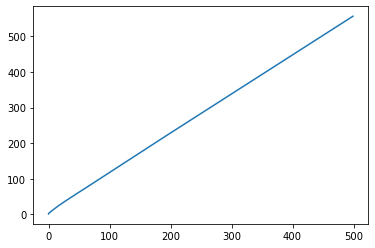

[9.38781698]
[67.00901535]
[130.13353859]
[272.46963203]
[3.93842434]
[5.44939264]


In [27]:
N = 3 # number of experiments
T = 500 # rounds per experiment
reg = np.zeros((N,T))
gamma = [0.1, 1, 10]

#statistics
stats = np.zeros((N, T, 6))

for u in range(N):
    mu = np.random.rand(m, n)
    mu_hat = np.zeros_like(mu) # empirical mean
    T_ij = np.ones_like(mu) # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(80, 120, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)

        fv, *stat = f(x_opt, y, mu, gamma)
        stats[u, t] = np.array([fv, *stat])

        if 'optimal' not in status:
            print('Solution infeasible')
            break

        rho_ij = np.sqrt(3*np.log(t+1)/(2*T_ij))
        mu_bar = np.max(mu_hat - rho_ij, 0) # LCB
        
        x_t, f_t, status = oracle(y, mu_bar, gamma)
        f_t, *_ = f(x_t, y, mu, gamma)
        
        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]        
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:,i])
            if j != 0:
                j -= 1
                c_ij = int(np.random.rand() < mu[i,j])
                T_ij[i, j] += 1
                mu_hat[i, j] += (c_ij - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt      
        
plt.plot(np.cumsum(reg,axis=1).T)
plt.show()
print(np.average(stats[:,:,0], 1))
print(np.average(stats[:,:,1], 1))
print(np.average(stats[:,:,2], 1))
print(np.average(stats[:,:,3], 1))
print(np.average(stats[:,:,4], 1))
print(np.average(stats[:,:,5], 1))


x0y:	67.01 +- 8.13
xy:	122.96 +- 70.93
uxy:	20.79 +- 3.64
d:	4.02
e:	4.16
x0y:	67.01 +- 8.13
xy:	122.96 +- 8.10
uxy:	22.72 +- 5.11
d:	3.92
e:	4.54
x0y:	67.01 +- 8.13
xy:	122.16 +- 71.65
uxy:	20.62 +- 3.63
d:	4.02
e:	4.12
x0y:	52.59 +- 0.77
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.10
e:	6.75
x0y:	67.01 +- 8.13
xy:	102.36 +- 69.84
uxy:	17.06 +- 3.30
d:	4.12
e:	3.41
x0y:	47.64 +- 0.77
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.23
e:	6.75
x0y:	67.01 +- 8.13
xy:	115.76 +- 74.60
uxy:	19.36 +- 3.53
d:	4.07
e:	3.87
x0y:	50.99 +- 0.77
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.14
e:	6.75
x0y:	67.01 +- 8.13
xy:	143.56 +- 53.60
uxy:	25.21 +- 4.73
d:	3.90
e:	5.04
x0y:	57.94 +- 2.10
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	3.97
e:	6.75
x0y:	67.01 +- 8.13
xy:	116.36 +- 75.02
uxy:	19.46 +- 3.55
d:	4.07
e:	3.89
x0y:	51.14 +- 0.77
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.13
e:	6.75
x0y:	67.01 +- 8.13
xy:	143.16 +- 54.11
uxy:	25.12 +- 4.71
d:	3.90
e:	5.02
x0y:	57.84 +- 2.06
xy:	179.85 +- 56.40


/Users/yihu/opt/anaconda3/envs/Offloading-FL/lib/python3.9/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


x0y:	67.01 +- 8.13
xy:	136.76 +- 62.59
uxy:	23.62 +- 4.32
d:	3.95
e:	4.72
x0y:	56.24 +- 1.51
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.01
e:	6.75
x0y:	67.01 +- 8.13
xy:	135.36 +- 63.00
uxy:	23.34 +- 4.22
d:	3.95
e:	4.67
x0y:	55.89 +- 1.40
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.02
e:	6.75
x0y:	67.01 +- 8.13
xy:	131.36 +- 64.77
uxy:	22.52 +- 3.96
d:	3.97
e:	4.50
x0y:	54.89 +- 1.13
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.04
e:	6.75
x0y:	67.01 +- 8.13
xy:	137.76 +- 61.64
uxy:	23.85 +- 4.39
d:	3.94
e:	4.77
x0y:	56.49 +- 1.59
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.00
e:	6.75
x0y:	67.01 +- 8.13
xy:	119.36 +- 74.31
uxy:	20.04 +- 3.59
d:	4.05
e:	4.01
x0y:	51.89 +- 0.77
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.11
e:	6.75
x0y:	67.01 +- 8.13
xy:	135.16 +- 63.07
uxy:	23.30 +- 4.21
d:	3.95
e:	4.66
x0y:	55.84 +- 1.38
xy:	179.85 +- 56.40
uxy:	33.77 +- 8.34
d:	4.02
e:	6.75
x0y:	67.01 +- 8.13
xy:	126.36 +- 68.10
uxy:	21.49 +- 3.74
d:	3.99
e:	4.30
x0y:	53.64 +- 0.85
xy:	179.85 +- 56.40

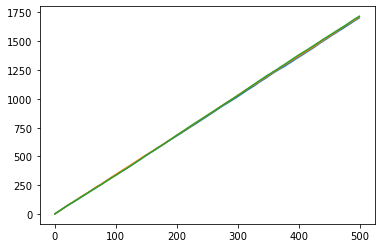

In [11]:
N = 3 # number of experiments
T = 500 # rounds per experiment
reg = np.zeros((N,T))
gamma = 1
for u in range(N):
    mu = trace_gen.avg()
    mu_hat = np.zeros_like(mu) # empirical mean
    T_ij = np.ones_like(mu) # total number of times arm (i,j) is played
    for t in range(T):
        y = np.random.uniform(80, 120, m).astype(int)
        x_opt, f_opt, status = oracle(y, mu, gamma)
        f(x_opt, y, mu, gamma)
        if 'optimal' not in status:
            print('Solution infeasible')
            break

        rho_ij = np.sqrt(3*np.log(t+1)/(2*T_ij))
        mu_bar = np.max(mu_hat - rho_ij, 0) # LCB

        x_t, f_t, status = oracle(y, mu_bar, gamma)
        f_t = f(x_t, y, mu, gamma)

        # sample j based on x_t[i], observe c_ij, update mu_hat[i,j]
        c = trace_gen.generate()
        for i in range(m):
            j = np.random.choice(n+1, p=x_t[:,i])
            if j != 0:
                j -= 1
                T_ij[i, j] += 1
                mu_hat[i, j] += (c[i,j] - mu_hat[i, j]) / T_ij[i, j]

        # calculate regert
        reg[u, t] = f_t - f_opt

plt.plot(np.cumsum(reg,axis=1).T)
plt.show()



